# Kalorimetrie Laborversuch

Author: Erwin Durasow

Datum: 12.12.2023

Gruppe: 79

## Forschungsfrage

Wie beeinflusst die Einhaltung des FAIR-Datenprinzips, insbesondere in Bezug auf Datensicherheit und -zugänglichkeit, die Genauigkeit und Reproduzierbarkeit der spezifischen Wärmekapazitätsbestimmung im Labor? Der Versuch untersucht, inwiefern die Prinzipien der Auffindbarkeit, Zugänglichkeit, Interoperabilität und Nachvollziehbarkeit von Forschungsdaten die Qualität der experimentellen Daten beeinflussen, während die Kalorimeterkonstante bestimmt und die spezifische Wärmekapazität von drei Proben gemessen wird.

## Versuchsaufbau und Durchführung

Der Versuchsaufbau besteht aus einem Topf mit Siedegarrer, welcher genau auf 60° eingestellt ist. Dort befinden sich die Proben bevor sie weiter verwendet werden. In einem weiteren Behälter befinden sich genau 400g Wasser, drei Temperatur Sensoren, einen Tauchsieder, sowie einem Magnetrührer eingestellt auf 1500 rpm. In einem ersten Versuch wird die Kaloremetriekonstante des Versuchaufbaus ohne Probe mit Tauchsieder ermittelt und anschließend mit Probe und ohne Tauchsieder. Dabei wird auch mittels eines weiteren Temperatursensors die Umgebungstemperatur gemessen. 

<img src="figures/calometry_laborversuch.jpg" width="800">


## Versuchsauswertung

In [595]:
import numpy as np
from matplotlib import pyplot as plt
import h5py as h5
import importlib

from functions import m_json
from functions import utility

# Use FST-Style, if you don't like it, you can safely delete this line.
plt.style.use("FST.mplstyle")


### Kalorimeterkonstante
Hinweis: Sie können die Funktion *get_json_entry* nutzen um auf Metadaten zuzugreifen. 

Für die Messdatenauswertung steht Ihnen bereits ein Modul utility.py zur Verfügung. Ergänzen sie die Funktionen im Modul zwischen TODO und DONE. Sie finden weitere Hinweise im jeweiligen Bereich TODO->DONE. 


#### (i) Messdaten einlesen
Lesen Sie die Messdaten in ihr Notebook ein.

In [596]:
# TODO: Define the path to hdf5 file, which containing experiment data for constant.

datafile_path_const = "data/dataConstant/dataConstant.h5"

# DONE #

In [597]:
importlib.reload(utility)

# TODO: Read all experimental data and associated metadata from HDF5 files for data processing.

group_path_const = "RawData"
data_dict = utility.get_plot_data_from_dataset(datafile_path_const, group_path_const)
# DONE #

In [598]:
# TODO: In order to be able to process data from sensors with the same position,
# it is first necessary to obtain the index of the sensors with different positions in the numpy.ndarray.
# List the index of all calorimeter sensors (index_calorimeter) and
# the environment sensor (index_environment).
# You can use this variables to easily get access to the correct measurement data later.

index_calorimeter = [0,1,2]
index_environment = [3]

# DONE #

#### (ii) Mittelwert und Standardabweichung für Plots bestimmen

Die Mittelwerte und Standardabweichungen der Messungen werden in der nächsten Sektion geplottet.

Nachdem die Mittelwerte und Standardabweichungen berechnet wurden, können Daten jeder Wärmequelle jeweils in einem numpy.ndarray gespeichert werden.

In [599]:
importlib.reload(utility)

# TODO: Calculate the average value and standard deviation of the calorimeter sensors and the environment sensor.
# You can use the indices from above.

mean_std_calorimeter = utility.cal_mean_and_standard_deviation(np.array(data_dict["temperature"])[index_calorimeter])
mean_std_environment = utility.cal_mean_and_standard_deviation((np.array(data_dict["temperature"])[index_environment]))
mean_data = [mean_std_calorimeter,mean_std_environment]


# DONE 

#### (iii) Daten ploten

Im Kalorimeter befinden sich mehrere Sensoren, deren Mittelwerte sowie Standardabweichungen der Messung an jeden Zeitpunkt bestimmt wurden. Die Messdaten bzw. ihre Mittelwerte sollen in einem Plot eingetragen werden. Die Standardabweichungen der Sensoren sind als Errorbar im Plot zu sehen.

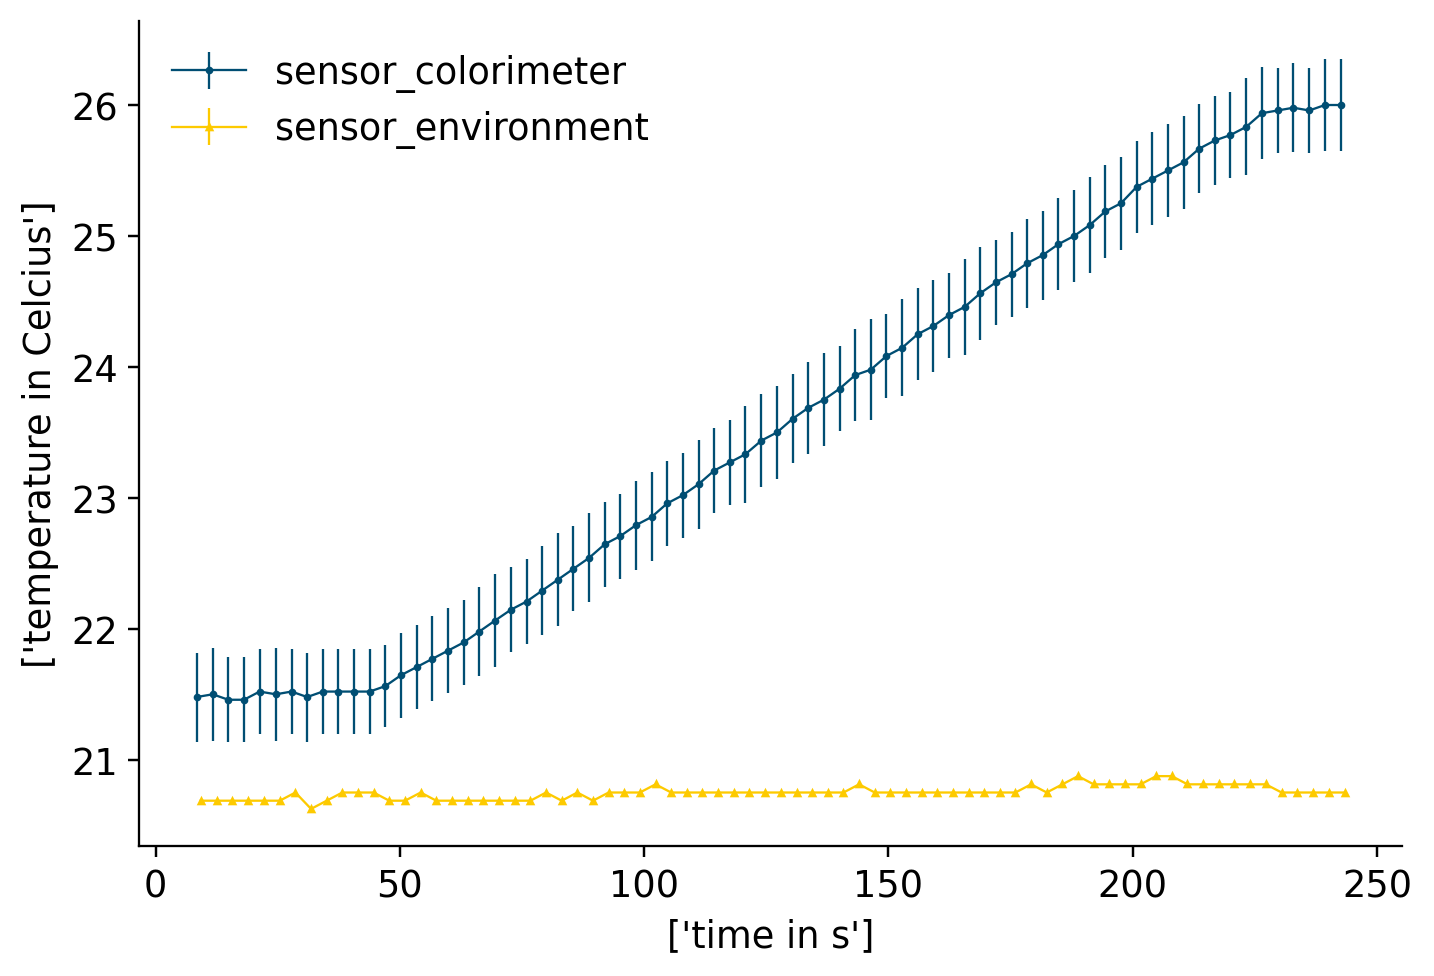

In [600]:
importlib.reload(utility)
# TODO: Use the temperature and time data for plotting

utility.plot_temp_over_time( mean_data,
                            data_dict["timestamp"], 
                            ["sensor_colorimeter","sensor_environment"], 
                            ["time in s"],
                            ["temperature in Celcius"] 
                           )

# DONE #

#### (iv) Metadaten auslesen

Die notwendigen Daten bzw. Metadaten für die Berechnung der Wärmekapazität wird ausgelesen.

In [601]:
# Heat capacity of Water has been given
water_heat_capa = 4.18

# TODO: Read mass of the water from the metadata of the experiment.

water_mass = m_json.get_json_entry('datasheets/', "1ee5ec0c-0b57-68cd-9d39-c9b7e9b18753", ["calorimeter", "medium",'mass', 'value'])

# DONE #

In [602]:
# TODO: Reading heater related data from hdf5 file, please use the same datafile_path_const variable for the HDF5 path.
# Hint: Note whether the data is stored as an array or a scalar in the hdf5 dataset.
current = None
heat_time = None
voltage = None
with h5.File(datafile_path_const) as data:
        group = data[group_path_const]
        
        for subgroup in group:
            try:
                current = np.array(group[subgroup]["current"])
                heat_time = np.array(group[subgroup]["heat_time"])
                voltage = np.array(group[subgroup]["voltage"])

                # Only group with dataset called current, heat_time and voltage will be read.
            except KeyError:
                continue

# DONE #

#### (v) Anfangs- und Endwert der Temperatur
Die Anfangs- und Endwert der Temperatur im Kloriemeter sind notwendig, um die Wärmekapazität zu bestimmen. 

Eine Möglichkeit wäre, durch das Maxium bzw. Minium und einen Schwellenwert ist ein Teil der Daten zu entnehmen. 

Daraus sind Mittelwerte zu berechnen. Die entsprechenden Mittelwerte können als Anfangs- und Endtemperatur verwendet werden.

In [603]:
importlib.reload(utility)

# TODO: Calculation of temperature data necessary to determine the specific heat capacity
temperature_end, temperature_start = utility.get_start_end_temperature(mean_std_calorimeter[0])
print(temperature_end,temperature_start)
# DONE #

25.952381 21.51488


#### (vi) Kalorimeterkonstante bestimmen
$$
C = \frac{UI\Delta t}{(T_2 - T_1)}
$$

In [604]:
# TODO: Calculate heat capacity of the calorimeter

calorimeter_const = (voltage*current*heat_time)/(temperature_end-temperature_start)

# DONE #

#### (Vii) Ergebnis

In [605]:
print("heat capacity of the calorimeter: ",calorimeter_const," J/K")

heat capacity of the calorimeter:  2028.168142327046  J/K


### spezifische Wärmekapazität: erste Probe


#### (i) Messdaten einlesen

In [606]:
# TODO: Define the path to hdf5 file, which containing experiment data for constant.

datafile_path_prob1 = "data/calometry_P006/calometry.h5"

# DONE #

In [607]:
importlib.reload(utility)

# TODO: Read all experimental data and associated metadata from HDF5 files for data processing.

group_path_const = "RawData"
data_dict = utility.get_plot_data_from_dataset(datafile_path_prob1, group_path_const)

# DONE #

In [608]:


# TODO: In order to be able to process data from sensors with the same position,
# it is first necessary to obtain the index of the sensors with different positions in the numpy.ndarray.

index_calorimeter = [0,1,2]
index_bath = [4]
index_env = [3]

# DONE #

#### (ii) Mittelwert und Standardabweichung für Plots bestimmen

In [609]:
importlib.reload(utility)

# TODO: Calculate the average value and standard deviation of sensors.

mean_std_calorimeter = utility.cal_mean_and_standard_deviation(data_dict["temperature"][index_calorimeter])
mean_std_environment = utility.cal_mean_and_standard_deviation(data_dict["temperature"][index_env])
mean_std_heater = utility.cal_mean_and_standard_deviation(data_dict["temperature"][index_bath])
mean_data = [mean_std_calorimeter,mean_std_environment, mean_std_heater]
print(mean_data)

# DONE #

[array([[20.145834  , 20.145834  , 20.145834  , 20.145834  , 20.125     ,
        20.145834  , 20.125     , 20.145834  , 20.208334  , 20.416666  ,
        20.729166  , 21.        , 21.1875    , 21.375     , 21.604166  ,
        21.75      , 21.875     , 21.958334  , 22.125     , 22.270834  ,
        22.333334  , 22.4375    , 22.520834  , 22.604166  , 22.666666  ,
        22.729166  , 22.8125    , 22.854166  , 22.916666  , 22.958334  ,
        23.041666  , 23.083334  , 23.104166  , 23.145834  , 23.208334  ,
        23.229166  , 23.270834  , 23.291666  , 23.333334  , 23.375     ,
        23.416666  , 23.416666  , 23.4375    , 23.5       , 23.5       ,
        23.520834  , 23.541666  , 23.583334  , 23.604166  , 23.604166  ,
        23.625     , 23.645834  , 23.666666  , 23.6875    , 23.708334  ,
        23.708334  , 23.729166  , 23.729166  , 23.729166  , 23.729166  ,
        23.75      , 23.770834  , 23.791666  , 23.791666  , 23.8125    ,
        23.8125    , 23.8125    , 23.791666  , 23.

#### (iii) Daten ploten

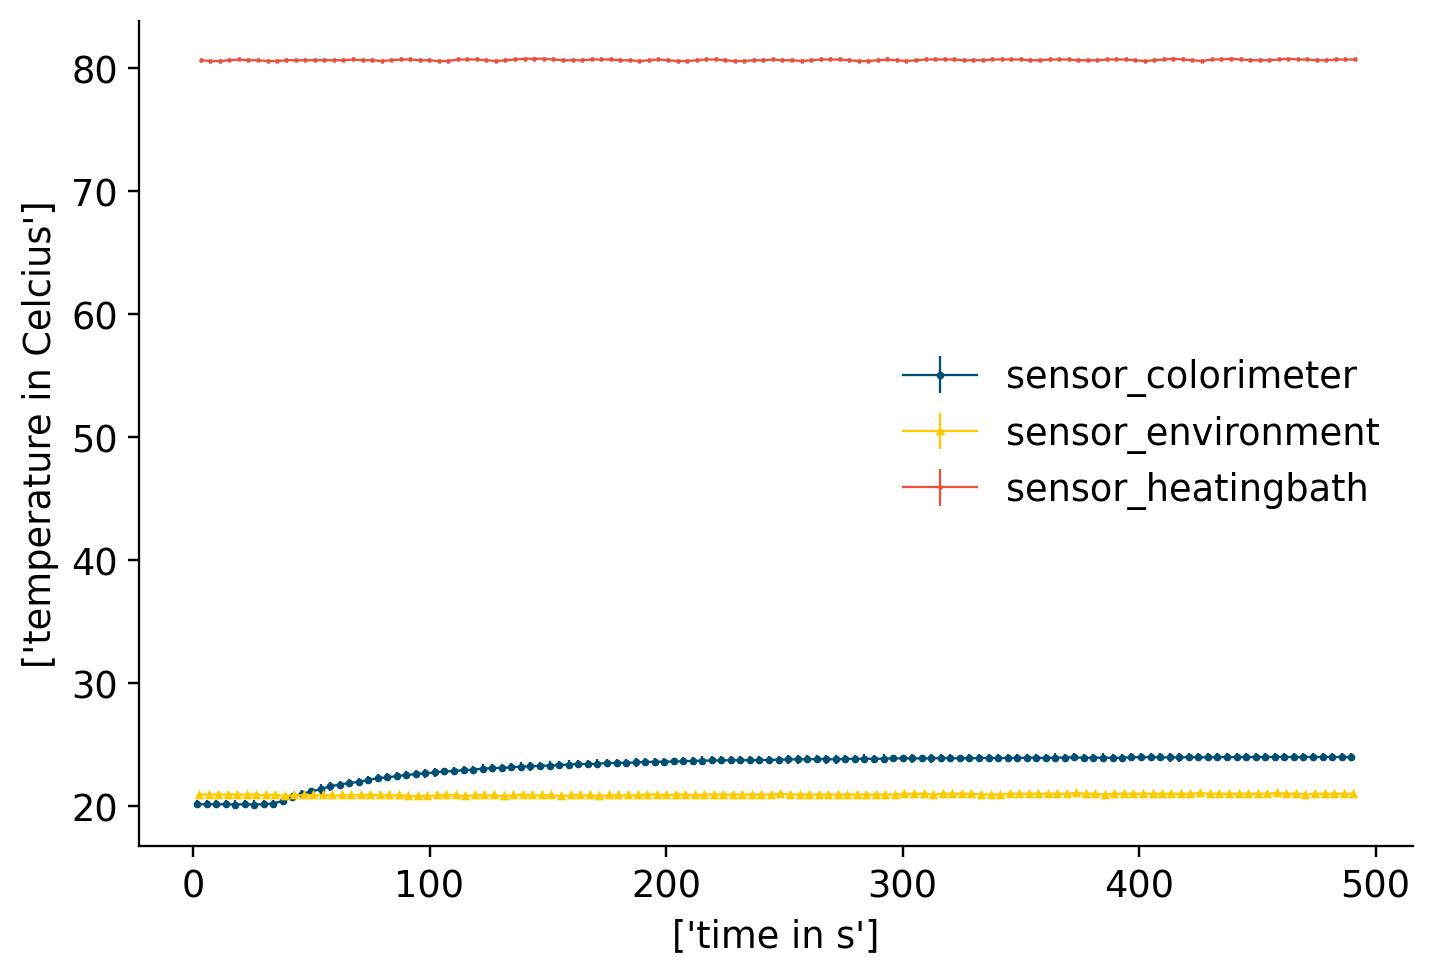

In [610]:
importlib.reload(utility)

# TODO: Use the temperature and time data for plotting.

utility.plot_temp_over_time( mean_data,
                            data_dict["timestamp"], 
                            ["sensor_colorimeter","sensor_environment","sensor_heatingbath"], 
                            ["time in s"],
                            ["temperature in Celcius"] 
                           )

# DONE #

#### (iv) Metadaten auslesen

In [611]:
# TODO: Read mass of the sample from the metadata of the experiment.

sample_mass = m_json.get_json_entry('datasheets/', "1ee57b31-ca65-62c8-bc60-327f1cbaf2f2", ["probe",'mass', 'value'])
print(sample_mass)
# DONE #

110


#### (v) Anfangs- und Endwert der Temperatur
Die Mischungstemperatur und Anfangstemperatur des Kalorimeters sind für die Berechnung relevant.

In [612]:
importlib.reload(utility)

# TODO: Calculation of temperature data necessary to determine the specific heat capacity

temperature_mix, temperature_start_water = utility.get_start_end_temperature(mean_std_calorimeter[0])
print(temperature_mix,temperature_start_water)

# DONE #

23.926168 20.148148


In [613]:
 # TODO

start_index = 0  # Start index after the beginning of the measurement
end_index = start_index + 10  # End index for the initial 10 data points

# Check if the array has enough data points
if end_index <= len(mean_std_heater[0]):
    # Slice the array to get the initial 10 data points
    initial_temperature_data = mean_std_heater[0][start_index:end_index]

    # Calculate the average initial temperature
    temperature_start_sample = np.mean(initial_temperature_data)
else:
    # Handle the case where there are not enough data points
    print("Not enough data points for calculating the initial temperature.")
    temperature_start_sample = None

# DONE #

#### (vi) spezifische Wärmekapazität bestimmen
$$
c_p = \frac{C(T_M-T_1)}{m_p(T_2-T_M)}
$$

In [614]:
# TODO: Calulate specific heat capacity of the sample.

sample_heat_capa = (calorimeter_const*(temperature_mix-temperature_start_water))/(sample_mass*(temperature_start_sample-temperature_mix))
print(sample_heat_capa)

# DONE #

1.2289810726114434


#### (Vii) Ergebnis

In [615]:
sample_heat_capa
print("heat capacity of the calorimeter: ",sample_heat_capa," J/K")

heat capacity of the calorimeter:  1.2289810726114434  J/K


### spezifische Wärmekapazität: zweite Probe


#### (i) Messdaten einlesen

In [616]:
# TODO: Define the path to hdf5 file, which containing experiment data for constant.

datafile_path_prob2 = "data/calometry_P011/calometry_P011.h5"

# DONE #

In [617]:
importlib.reload(utility)

# TODO: Read all experimental data and associated metadata from HDF5 files for data processing.

group_path_const = "RawData"
data_dict = utility.get_plot_data_from_dataset(datafile_path_prob2, group_path_const)

# DONE #

In [618]:
# TODO: In order to be able to process data from sensors with the same position,
# it is first necessary to obtain the index of the sensors with different positions in the numpy.ndarray.

index_calorimeter = [0,1,2]
index_bath = [4]
index_env = [3]

# DONE #

#### (ii) Mittelwert und Standardabweichung für Plots bestimmen

In [619]:
importlib.reload(utility)

# TODO: Calculate the average value and standard deviation of sensors.

mean_std_calorimeter = utility.cal_mean_and_standard_deviation(np.array(data_dict["temperature"])[index_calorimeter])
mean_std_environment = utility.cal_mean_and_standard_deviation(np.array(data_dict["temperature"])[index_env])
mean_std_heater = utility.cal_mean_and_standard_deviation(np.array(data_dict["temperature"])[index_bath])
mean_data = [mean_std_calorimeter,mean_std_environment, mean_std_heater]
# DONE #

#### (iii) Daten ploten

In [620]:
importlib.reload(utility)

# TODO: Use the temperature and time data for plotting.

utility.plot_temp_over_time( mean_data,
                            data_dict["timestamp"], 
                            ["sensor_colorimeter","sensor_environment","sensor_heatingbath"], 
                            ["time in s"],
                            ["temperature in Celcius"] 
                           )

# DONE #

#### (iv) Metadaten auslesen

In [621]:
# TODO: Read mass of the sample from the metadata of the experiment.

sample_mass = m_json.get_json_entry('datasheets/', "1ee57b37-1b00-6b47-b00e-8332e0df15ea", ["probe",'mass', 'value'])

# DONE #

#### (v) Anfangs- und Endwert der Temperatur

In [622]:
importlib.reload(utility)

# TODO: Calculation of temperature data necessary to determine the specific heat capacity

temperature_mix, temperature_start_water = utility.get_start_end_temperature(mean_std_calorimeter[0])
print(temperature_mix,temperature_start_water)
# DONE #

27.08449 19.7487


In [623]:
# TODO: Determine the initial temperature of the sample. 
# Since the temperature of the water bath is stable, the initial temperature
# of the sample can be taken as the average of the 10 data after the start of the measurement.

start_index = 0  # Start index after the beginning of the measurement
end_index = start_index + 10  # End index for the initial 10 data points

# Check if the array has enough data points
if end_index <= len(mean_std_heater[0]):
    # Slice the array to get the initial 10 data points
    initial_temperature_data = mean_std_heater[0][start_index:end_index]

    # Calculate the average initial temperature
    temperature_start_sample = np.mean(initial_temperature_data)
else:
    # Handle the case where there are not enough data points
    print("Not enough data points for calculating the initial temperature.")
    temperature_start_sample = None

# DONE #

#### (vi) spezifische Wärmekapazität bestimmen

In [624]:
# TODO: Calulate specific heat capacity of the sample.

sample_heat_capa = ((calorimeter_const*(temperature_mix-temperature_start_water))/(sample_mass*(temperature_start_sample-temperature_mix)))
print(sample_heat_capa)

# DONE #

0.4077242505313154


#### (Vii) Ergebnis

In [625]:
print("heat capacity of the calorimeter: ",sample_heat_capa," J/K")

heat capacity of the calorimeter:  0.4077242505313154  J/K


### spezifische Wärmekapazität: dritte Probe


#### (i) Messdaten einlesen

In [626]:
# TODO: Define the path to hdf5 file, which containing experiment data for constant.

datafile_path_prob3 = "data/calorimetry_P023/calorimetry_P023.h5"

# DONE #

In [627]:
importlib.reload(utility)

# TODO: Read all experimental data and associated metadata from HDF5 files for data processing.

group_path_const = "RawData"
data_dict = utility.get_plot_data_from_dataset(datafile_path_prob3, group_path_const)

# DONE #

In [628]:
# TODO: In order to be able to process data from sensors with the same position,
# it is first necessary to obtain the index of the sensors with different positions in the numpy.ndarray.

index_calorimeter = [0, 1, 2]
index_bath = [4]
index_env = [3]

# DONE #

#### (ii) Mittelwert und Standardabweichung für Plots bestimmen

In [629]:
importlib.reload(utility)

# TODO: Calculate the average value and standard deviation of sensors.

mean_std_calorimeter = utility.cal_mean_and_standard_deviation(data_dict["temperature"][index_calorimeter])
mean_std_environment = utility.cal_mean_and_standard_deviation(data_dict["temperature"][index_env])
mean_std_heater = utility.cal_mean_and_standard_deviation(data_dict["temperature"][index_bath])
mean_data = [mean_std_calorimeter,mean_std_environment, mean_std_heater]
# DONE #

#### (iii) Daten ploten

In [630]:
importlib.reload(utility)

# TODO: Use the temperature and time data for plotting.

utility.plot_temp_over_time( mean_data,
                            data_dict["timestamp"], 
                            ["sensor_colorimeter","sensor_environment","sensor_heatingbath"],
                            ["time in s"],
                            ["temperature in Celcius"] 
                           )
# DONE #

#### (iv) Metadaten auslesen

In [631]:
# TODO: Read mass of the sample from the metadata of the experiment.

sample_mass = m_json.get_json_entry('datasheets/', "1ee7d443-5a29-6863-bb97-27e7763ee3fd", ["probe",'mass', 'value'])

# DONE #

#### (v) Anfangs- und Endwert der Temperatur

In [632]:
importlib.reload(utility)

# TODO: Calculation of temperature data necessary to determine the specific heat capacity
temperature_mix, temperature_start_water = utility.get_start_end_temperature(mean_std_calorimeter[0])
print(temperature_mix,temperature_start_water)

# DONE #

23.951727 19.976562


In [633]:
# TODO: Determine the initial temperature of the sample. 
# Since the temperature of the water bath is stable, the initial temperature
# of the sample can be taken as the average of the 10 data after the start of the measurement.
start_index = 0  # Start index after the beginning of the measurement
end_index = start_index + 10  # End index for the initial 10 data points

# Check if the array has enough data points
if end_index <= len(mean_std_heater[0]):
    # Slice the array to get the initial 10 data points
    initial_temperature_data = mean_std_heater[0][start_index:end_index]

    # Calculate the average initial temperature
    temperature_start_sample = np.mean(initial_temperature_data)
else:
    # Handle the case where there are not enough data points
    print("Not enough data points for calculating the initial temperature.")
    temperature_start_sample = None


# DONE #

#### (vi) spezifische Wärmekapazität bestimmen

In [634]:
# TODO: Calulate specific heat capacity of the sample.

sample_heat_capa = (calorimeter_const*(temperature_mix-temperature_start_water))/(sample_mass*(temperature_start_sample-temperature_mix))
print(sample_heat_capa)

# DONE #

1.7101958305430642


#### (Vii) Ergebnis

In [635]:
print("heat capacity of the calorimeter: ",sample_heat_capa," J/K")

heat capacity of the calorimeter:  1.7101958305430642  J/K


## Diskussion
Wenn man die spezifischen Wärmekapazitäten mit Tabellenwerten vergleicht sieht man, dass zwar ein Unterschied besteht, aber dieser durch menschliche Fehler zurückzuführen sind. P006 : c_PVC_exp=1.23 c_PVC_real= 0,85, P011 : c_Messing_exp=0.408 c_Messing_real= 0,377, P023 : c_ABS_exp=1.71 c_ABS_real= 1.40. Um genauere Ergebnisse zu erhalten sollte die kurze Messdauer erhöht werden.

## Fazit
Das Experiment hat gezeigt wie wichtig Metadaten sein können um die plausibilität von Messergebnissen zu bestätigen.